In [1]:
from activity_1 import variance, arithmetic_average, std_dev
from activity_2 import confidence_interval
from math import sqrt, fabs, floor
import numpy as np
from queue import Queue
from scipy.stats import t
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

%matplotlib inline

In [2]:
def get_mean_waiting_theoric(lambda_, mi, is_m=True, K=1):
    ro = lambda_ / mi
    
    if is_m:
        return ro / (mi * (1 - ro))
    
    else:
        numerator = ro * (1 + (1 / K))
        denominator = 2 * mi * (1 - ro)
        
        return numerator / denominator

In [3]:
def get_contains_percent_value(turns, theoric_value):
    total = len(turns)
    partial = 0
    
    for turn in turns:
        min_value = turn['mean'] - turn['confidence_interval']
        max_value = turn['mean'] + turn['confidence_interval']
        if min_value <= theoric_value <= max_value:
            partial += 1
            
    return partial / total

In [4]:
def get_r_bar(mean_buckets, B):
    comb_mean_buckets = list(combinations_with_replacement(mean_buckets, r=2))
    count = [
        1
        for mean_buckets
        in comb_mean_buckets
        if mean_buckets[0] != mean_buckets[1]
        and mean_buckets[1] <= mean_buckets[0]
    ]

    return sum(count) / B

In [5]:
def mser(data, n=5):
    data_size = len(data)
    K = data_size // n
    
    z_values = [
        arithmetic_average(data[i : i+n])
        for i
        in range(0, data_size, n)
    ]
    
    d_values = []
    for d in range(K//2 + floor(sqrt(K))):
        mser_5y = variance(z_values[d:]) / sqrt(K - d)
        d_values.append(mser_5y)
        
    d = d_values.index(min(d_values))
    
    if d < K//2 and d != 0:
        return (data[d * n:], True)
    else:
        return (data, False)

In [6]:
def simulate_queue(lambda_, mi, n):
    global queue, clock_current
    time_arrival = 1 / lambda_
    time_attendance = 1 / mi
    queue = Queue()
    times_waiting = []
    
    for i in range(n):
        exp_arrival = np.random.exponential(time_arrival)
        exp_attendance = np.random.exponential(time_attendance)
        
        if queue.empty():
            clock_current += exp_arrival
            queue.put(clock_current)
            
        else:
            clock_simulation = clock_current
            
            while clock_current < clock_simulation + exp_arrival and not queue.empty():
                time_waiting = clock_current - queue.get()
                clock_current += exp_attendance
                times_waiting.append(time_waiting)

            if clock_current < clock_simulation + exp_arrival:
                clock_current = clock_simulation + exp_arrival
                queue.put(clock_current)
            else:
                time_to_put = clock_simulation + exp_arrival
                queue.put(time_to_put)

    while not queue.empty():
        time_waiting = clock_current - queue.get()
        clock_current += np.random.exponential(time_attendance)
        times_waiting.append(time_waiting)
        
    return times_waiting

In [7]:
def run(lambda_, mi, B=20, M = 100, a=0.01, relative_precision=0.05):
    value_tabulated_von_neumann = 1.03
    size_values = B*M
    global queue, clock_current
    queue = Queue()
    clock_current = 0
       
    while True:
        times_queue = simulate_queue(lambda_, mi, size_values)
        elements_transient, find_transient = mser(times_queue)
        if find_transient:
            break
    
    values_to_complete = simulate_queue(lambda_, mi, size_values - len(elements_transient))
    elements_transient.extend(values_to_complete)
    rvn = -1
    e = 2
    
    while True:
        if rvn != -1:
            M += 100
            size_values = B*M
            values_to_complete = simulate_queue(lambda_, mi, size_values - len(elements_transient))
            elements_transient.extend(values_to_complete)
            
        mean_buckets = [
            arithmetic_average(elements_transient[i:i+M])
            for i
            in range(0, len(elements_transient), M)
        ]
        
        if rvn <= value_tabulated_von_neumann:
            r_bar = get_r_bar(mean_buckets, B)
            
            numerator = sum([
                (mean_buckets[i] - mean_buckets[i+1])**2
                for i
                in range(B-1)
            ])
            denominator = sum([
                (mean_buckets[i] - r_bar)**2
                for i
                in range(B)
            ])

            rvn = numerator / denominator
            
        x_bar = arithmetic_average(mean_buckets)
        h = t.ppf(1-a/2, B-1) * std_dev(mean_buckets) / sqrt(size_values)
        e = h/x_bar
        
        if rvn <= value_tabulated_von_neumann or e > relative_precision:
            break
    
    return x_bar, h

In [8]:
turns = []
running_times = 100
lambda_ = 0.25
mi = 10.0

for _ in range(100):
    mean, h = run(lambda_, mi)
    turn = {
        'mean': mean,
        'confidence_interval': h
    }
    turns.append(turn)

In [9]:
x = [i for i in range(0, running_times)]
y = [turn['mean'] for turn in turns]
errors = [turn['confidence_interval'] for turn in turns]

# mean line
theoric_value = get_mean_waiting_theoric(lambda_, mi)
x_mean = [i for i in range(0, running_times)]
y_mean = [theoric_value for _ in range(running_times)]

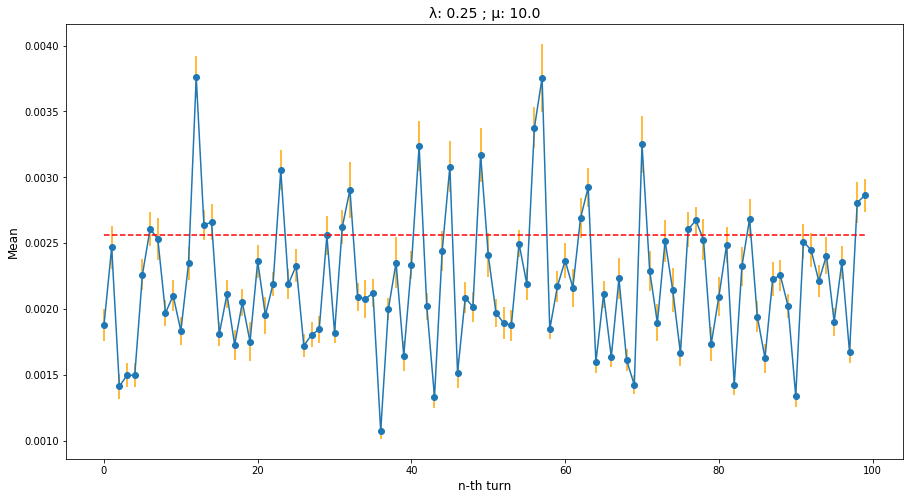

In [10]:
fig,ax = plt.subplots(figsize=(15, 8))
plt.title(f'λ: {lambda_} ; μ: {mi}', fontsize=14)
ax.errorbar(x,y,yerr=errors, fmt='-o', ecolor='orange')
ax.errorbar(x_mean,y_mean, fmt='--r')
plt.xlabel('n-th turn', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.show()

In [11]:
contains_percent_value = get_contains_percent_value(turns, theoric_value)

print(f'For λ: {lambda_} and μ: {mi}, the theoric value is {theoric_value}')
print(f'The coverage of the confidence interval containing the theoric value is {contains_percent_value}')

For λ: 0.25 and μ: 10.0, the theoric value is 0.002564102564102564
The coverage of the confidence interval containing the theoric value is 0.18


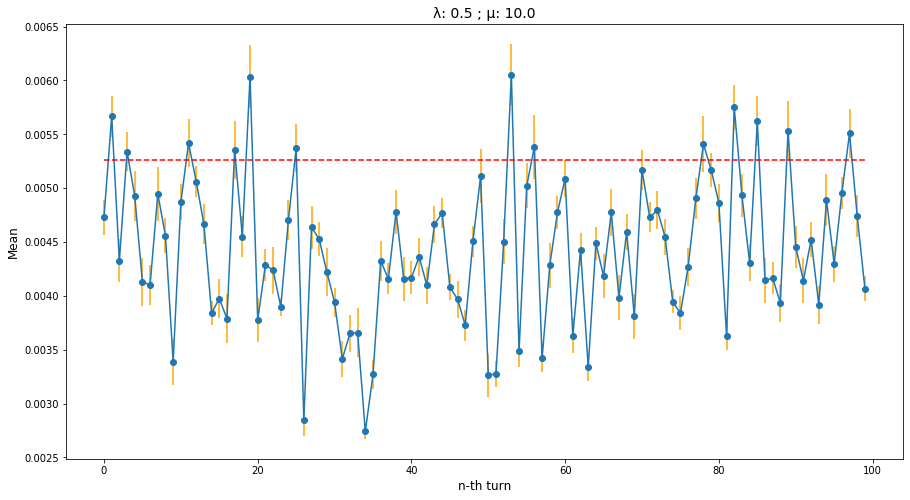

For λ: 0.5 and μ: 10.0, the theoric value is 0.005263157894736842
The coverage of the confidence interval containing the theoric value is 0.1


In [12]:
turns = []
running_times = 100
lambda_ = 0.5
mi = 10.0

for _ in range(running_times):
    turn = {}
    mean, h = run(lambda_, mi)
    turn['mean'] = mean
    turn['confidence_interval'] = h
    turns.append(turn)

x = [i for i in range(0, running_times)]
y = [turn['mean'] for turn in turns]
errors = [turn['confidence_interval'] for turn in turns]

# mean line
x_mean = [i for i in range(0, running_times)]
theoric_value = get_mean_waiting_theoric(lambda_, mi)
y_mean = [theoric_value for _ in range(running_times)]

fig,ax = plt.subplots(figsize=(15, 8))
plt.title(f'λ: {lambda_} ; μ: {mi}', fontsize=14)
ax.errorbar(x,y,yerr=errors, fmt='-o', ecolor='orange')
ax.errorbar(x_mean,y_mean, fmt='--r')
plt.xlabel('n-th turn', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.show()

contains_percent_value = get_contains_percent_value(turns, theoric_value)

print(f'For λ: {lambda_} and μ: {mi}, the theoric value is {theoric_value}')
print(f'The coverage of the confidence interval containing the theoric value is {contains_percent_value}')

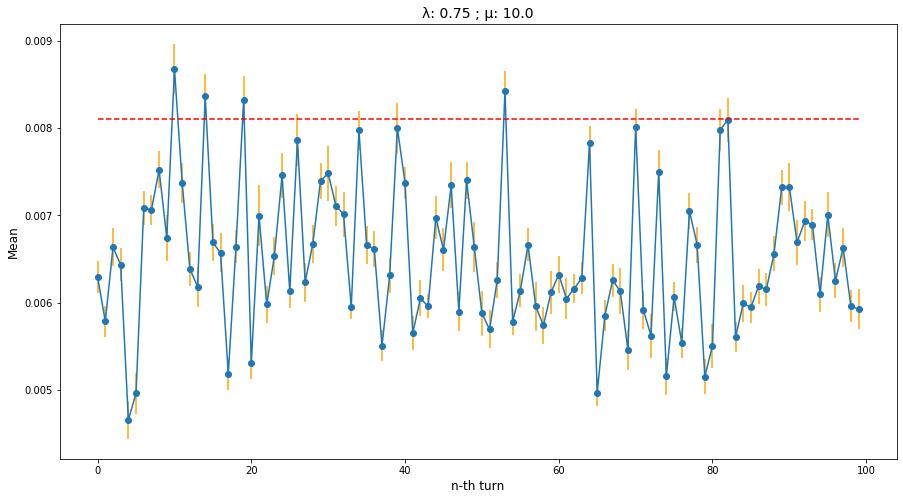

For λ: 0.75 and μ: 10.0, the theoric value is 0.008108108108108109
The coverage of the confidence interval containing the theoric value is 0.08


In [13]:
turns = []
running_times = 100
lambda_ = 0.75
mi = 10.0

for _ in range(running_times):
    turn = {}
    mean, h = run(lambda_, mi)
    turn['mean'] = mean
    turn['confidence_interval'] = h
    turns.append(turn)

x = [i for i in range(0, running_times)]
y = [turn['mean'] for turn in turns]
errors = [turn['confidence_interval'] for turn in turns]

# mean line
x_mean = [i for i in range(0, running_times)]
theoric_value = get_mean_waiting_theoric(lambda_, mi)
y_mean = [theoric_value for _ in range(running_times)]

fig,ax = plt.subplots(figsize=(15, 8))
plt.title(f'λ: {lambda_} ; μ: {mi}', fontsize=14)
ax.errorbar(x,y,yerr=errors, fmt='-o', ecolor='orange')
ax.errorbar(x_mean,y_mean, fmt='--r')
plt.xlabel('n-th turn', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.show()

contains_percent_value = get_contains_percent_value(turns, theoric_value)

print(f'For λ: {lambda_} and μ: {mi}, the theoric value is {theoric_value}')
print(f'The coverage of the confidence interval containing the theoric value is {contains_percent_value}')

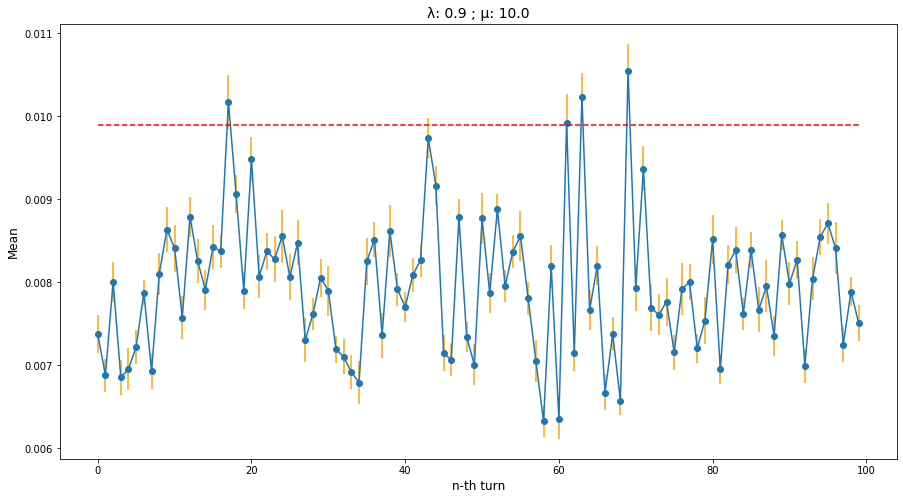

For λ: 0.9 and μ: 10.0, the theoric value is 0.00989010989010989
The coverage of the confidence interval containing the theoric value is 0.03


In [14]:
turns = []
running_times = 100
lambda_ = 0.9
mi = 10.0

for _ in range(running_times):
    turn = {}
    mean, h = run(lambda_, mi)
    turn['mean'] = mean
    turn['confidence_interval'] = h
    turns.append(turn)

x = [i for i in range(0, running_times)]
y = [turn['mean'] for turn in turns]
errors = [turn['confidence_interval'] for turn in turns]

# mean line
x_mean = [i for i in range(0, running_times)]
theoric_value = get_mean_waiting_theoric(lambda_, mi)
y_mean = [theoric_value for _ in range(running_times)]

fig,ax = plt.subplots(figsize=(15, 8))
plt.title(f'λ: {lambda_} ; μ: {mi}', fontsize=14)
ax.errorbar(x,y,yerr=errors, fmt='-o', ecolor='orange')
ax.errorbar(x_mean,y_mean, fmt='--r')
plt.xlabel('n-th turn', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.show()

contains_percent_value = get_contains_percent_value(turns, theoric_value)

print(f'For λ: {lambda_} and μ: {mi}, the theoric value is {theoric_value}')
print(f'The coverage of the confidence interval containing the theoric value is {contains_percent_value}')

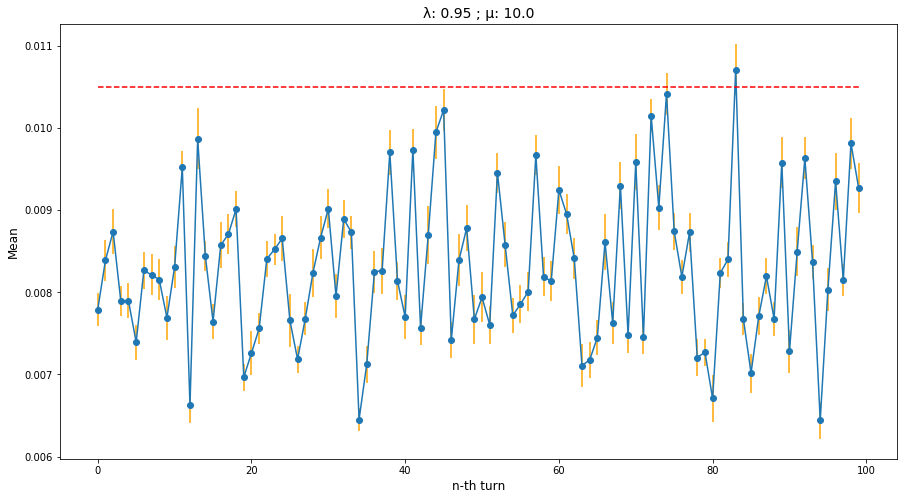

For λ: 0.95 and μ: 10.0, the theoric value is 0.010497237569060772
The coverage of the confidence interval containing the theoric value is 0.02


In [15]:
turns = []
running_times = 100
lambda_ = 0.95
mi = 10.0

for _ in range(running_times):
    turn = {}
    mean, h = run(lambda_, mi)
    turn['mean'] = mean
    turn['confidence_interval'] = h
    turns.append(turn)

x = [i for i in range(0, running_times)]
y = [turn['mean'] for turn in turns]
errors = [turn['confidence_interval'] for turn in turns]

# mean line
x_mean = [i for i in range(0, running_times)]
theoric_value = get_mean_waiting_theoric(lambda_, mi)
y_mean = [theoric_value for _ in range(running_times)]

fig,ax = plt.subplots(figsize=(15, 8))
plt.title(f'λ: {lambda_} ; μ: {mi}', fontsize=14)
ax.errorbar(x,y,yerr=errors, fmt='-o', ecolor='orange')
ax.errorbar(x_mean,y_mean, fmt='--r')
plt.xlabel('n-th turn', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.show()

contains_percent_value = get_contains_percent_value(turns, theoric_value)

print(f'For λ: {lambda_} and μ: {mi}, the theoric value is {theoric_value}')
print(f'The coverage of the confidence interval containing the theoric value is {contains_percent_value}')